In [2]:
%run stdPackages.ipynb

# A Basic Model of the Electricity System

In this exercise, we'll consider a basic model of the electricity system. In **Q1**, we solve a very simple model using pen and paper methods. In **Q2** we implement a simple numerical version of this, setting up the appropriate structure to solve it using the ```scipy.optimize.linprog``` method.

## Q1. Characterize Model

Consider a stylized, static model of the electricity wholesale market where a portfolio of different dispatchable generators (indexed by $i$) competes to serve a fixed load $L$ MWh. Let $E_i$ denote the generated electricity by generator $i$ measured in MWh and $q_i$ the installed hourly generating capacity in MW. The generators use a combination of primary energy carriers (indexed by $j$) and an aggregate of other inputs ($oth$). Let $\mu_j^i$ denote the input share of energy carrier $j$ for generator $i$ -- i.e. MWh input of energy carrier $j$ per MWh electricity output. Let $p_j^f$ denote the price of carrier $j$ measured in €/MWh. The use of primary carriers ($j$) is tied to \CO2 emissions in fixed ratios.

### **Q1.1: Briefly explain the optimization problem in equations (1).**
$\begin{align}
    \min \ \sum_i& c_i E_i \tag{1a} \\
    \text{subject to }L&=\sum_i E_i \tag{1b} \\ 
    c_i &= c_i^{oth}+\sum_j\mu_j^i p_j^f, \qquad \forall i \tag{1c}\\ 
    E_i &\in[0, q_i], \qquad \forall i. \tag{1d}
\end{align}$

1a, minimizing the costs of energy production
1b, total demand has to equal total supply (equilibrium constraint)
1c, marginal costs given by marginal costs other than material costs + marginal material costs of producing one mwh of dndfyunit o co2 
1d, Generator i can produce between 0 and a maximum $q_i$ amount of energy 

### **Q1.2:**

*Let $\phi_j$ denote the emission intensity of energy carrier $j$ measured in ton CO2/MWh. Assume that we have an estimate of the social cost of carbon of $p_{CO2}$ €/ton CO2.*


*Briefly explain the problem in equations (2). What does the new parameter $v_i$ measure?*
\begin{align}
    \min \ \sum_i& \left(c_i+v_i\cdot p_{CO2}\right) E_i \tag{2a}\\
    \text{subject to }L&=\sum_i E_i \tag{2b} \\ 
    v_i &= \sum_j\mu_j^i\phi_j \tag{2c} \\
    E_i &\in[0, q_i], \qquad \forall i. \tag{2d}
\end{align}

2a, minimizing the costs of energy production that now include costs from co2 emissions
2b, equilibrium constraint
2c, marginal costs given by marginal costs other than material costs + sum of the input share of energy carrier j for generator i in MWh * price of carrier j per MWh
1d, The amount of energy produced by generator i is between 0 and its maximum output 

### **Q1.3**
*Derive the first order conditions for the problem in (2b). Give a brief interpretation.*

L = $\sum(c_i+v_ip_{co2}E_i)+$

### **Q1.4. Merit order curve and solution**

The file *PS3\_Q1_tables.xlsx* includes a small dataset with three generators. Tables 1-2 translates the names used in the data to the symbols used in the model above. 

| **Table 1: Symbols Dictionary** | |
| --- | --- |
| *Name in excel data* | *Model Symbol* |
| FuelMix | $\mu_j^i$ |
| EmissionIntensity | $\phi_j$ |
|FuelPrice | $p_j^f$ |
| EmissionTax | $p_{CO2}$ |
| Load | $L$ |
| GeneratingCapacity | $q_i$ |
| OtherMC | $c_i^{oth}$ |

| **Table 2: Index Dictionary** | |
| --- | --- |
| *Name in excel data* | *Model Index* |
| BFt | $j$ |
| id | $i$ |

*The following uses the package ```pyDbs``` to load and arrange the data in a simple key,value like database. It has a few methods that reads in symbols from excel and add them as pandas series with the appropriate pandas indices. This is what we use here to read in the data:*

In [12]:
import pyDbs
db = pyDbs.read.dbFromWB(os.path.join(d['data'], 'PS3_Q1.xlsx'),
                        {'variables': ['Fundamentals','Load','Generator'],
                         'variable2D': ['FuelMix'],
                         'maps': ['GeneratorCategories']})
pyDbs.readSets(db) # this method adds indices from the declared symbols to the database.



*This database stores symbols in ```self.symbols```; you can get the symbols using simple 'slicing' syntax, e.g. the index for plants:*

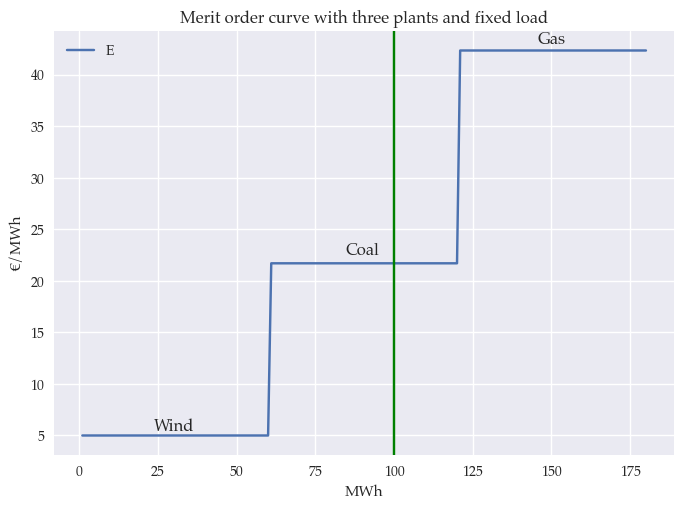

In [163]:
gj = pd.Index(np.arange(1,181,1))
p_c = [2*db['FuelPrice']['Coal']+(db['EmissionIntensity']['Coal']['CO2']*db['EmissionTax']['CO2'])+db['OtherMC']['A']]*db['GeneratingCapacity']['A']
p_g = [2*db['FuelPrice']['Natural gas']+(db['EmissionIntensity']['Natural gas']['CO2']*db['EmissionTax']['CO2'])+db['OtherMC']['B']]*db['GeneratingCapacity']['B']
p_w = [0+db['OtherMC']['C']]*db['GeneratingCapacity']['C']
E_total = pd.Series(p_w + p_c + p_g, index = gj, name = 'E')
E_total.plot()
plt.axvline(100, color='g')
plt.annotate(
    'Wind',   # The description text
    xy=(30, 5),  # The point to annotate
    xytext=(30, 5 + 0.5),  # Position of the text (above the point)
    fontsize=12,
    ha='center'  # Horizontal alignment of text
)
plt.annotate(
    'Coal',   # The description text
    xy=(90, 22),  # The point to annotate
    xytext=(90, 22 + 0.5),  # Position of the text (above the point)
    fontsize=12,
    ha='center'  # Horizontal alignment of text
)
plt.annotate(
    'Gas',   # The description text
    xy=(150, 42.5),  # The point to annotate
    xytext=(150, 42.5 + 0.5),  # Position of the text (above the point)
    fontsize=12,
    ha='center'  # Horizontal alignment of text
)
plt.xlabel('MWh')
plt.ylabel('€/MWh')
plt.title('Merit order curve with three plants and fixed load')
plt.legend()
plt.grid(True)
plt.show()

*Based on this small dataset, draw the merit-order curve and compute the solution for $E_i$ and $\lambda$.*

### **Q1.5. A Cap on Emissions**

Assume that, instead of having a price on CO2 emissions $(p_{CO2})$, we implement a cap on CO2 emissions as follows:
\begin{align}
    \sum_i v_i\cdot E_i \leq \overline{CO2}. \tag{4}
\end{align}
*Adjust the Lagrange in (3) appropriately and derive the first order conditions again.*

### **Q1.6. Interpretation of shadow variable $\theta^{CO2}$**

In **Q1.4** we used a price on\CO2 emissions of 5€. This resulted in roughly 27.2 tonnes of CO2 emissions in optimum. Now, in the emissions cap scenario (**Q1.5**), let $\theta^{CO2}$ denote the shadow cost of the constraint in (4) and assume that we fix the cap at $\overline{CO2}=$25 tonnes instead. 


*Give an interpretation of what $\theta^{CO2}$ measures. Based on the small data set, what is the value in this model with $\overline{CO2}=$25?*

## Q2. Numerical implementation

The algorithm in ```scipy.optimize.linprog``` solves what we will refer to as an "augmented form" of the linear program (as opposed to the "standard form" that does not feature explicit equality constraints):

$$\begin{align} 
    &\min_{x} \ c^T\cdot x \tag{5a}\\ 
    &A_{ub}\times x \leq b_{ub} \tag{5b}\\ 
    &A_{eq}\times x  = b_{eq} \tag{5c}\\ 
    &l\leq x\leq u, \tag{5d}
\end{align}$$
where: 
* $x$ is the vector of choice variables of length ($N$).
* $c, l, u$ are coefficient vectors of the same length ($N$).
* $b_{eq}, b_{ub}$ are coefficient vectors of lengths $N_{eq}, N_{ub}$, 
* and $A_{eq}, A_{ub}$ are coefficient matrices of sizes $(N_{eq}\times N)$ and $(N_{ub} \times N)$ respectively.

We will generally refer to the inequality constraints $l\leq x \leq u$ as *domain constraints*, whereas the constraints that combine multiple variables as *variational constraints* (1B-1C). 

At its core, the ```scipy.optimize.linprog``` takes inputs in the form of arrays (e.g. ```np.arrays```), which means that we have to be careful with the ordering of variables and constraints: The $n$'th element in $c$ represents the same element as the $n$'th elements in $l,u$ and the $n$'th column vectors in $A_{ub}, A_{eq}$. Thus, when solving a model with many different types of constraints and variables, the task of constructing suitable vectors / matrices becomes quite cumbersome. In the simple model from **Q1**, however, it is very simple.

### **Q2.1. Set up relevant vectors and matrices for the model in Q1.3. Solve it numerically.**

*Hint: You need to create relevant components (```c```, ```b_eq```, ```A_eq```, ```l```, ```u```) and then call*

```python
optimize.linprog(c, A_eq = A_eq, b_eq = b_eq, bounds = np.vstack([l, u]).T)
```

### **Q2.2. Add the emission cap from (4) with $\overline{CO2} = 25$ to the model and solve.**